## University of California - Irvine
### Bank Marketing Data Set

### From UCI:
**Input variables:**

**bank client data:**
- 1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign:**
- 8 - contact: contact communication type (categorical: 'cellular','telephone') 
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**
- 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import sklearn.metrics as metrics

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_original=pd.read_csv("c:/data/bank-additional-full.csv",sep=';')
df_original=df_original.drop(['duration'],axis=1) # Per instructions from UC Irvine 
df_original.loc[df_original.pdays == 999, 'pdays'] = np.nan # 999 = No data from UCI.
df = df_original.copy()

print(df.shape)
display(df.head())

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Extend the DataFrame describe() method to show nunique, null counts and column type. 

In [3]:
def extended_describe(df):
    de = df.describe()

    nu = pd.DataFrame(df.nunique())
    nu.columns = ['nunique']
    nu = nu.transpose()

    nan = pd.DataFrame(df.isnull().sum(axis=0))
    nan.columns = ['nan']
    nan = nan.transpose()

    de = de.append([nu, nan], sort=False).transpose()
    de['categorical'] = de['count'].isnull()
    de.index.name = 'column'
    return de

In [4]:
de = extended_describe(df)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,78.0,0.0,False
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000,42.0,0.0,False
pdays,1515.0,6.014521,3.824906,0.000,3.000,6.000,7.000,27.000,26.0,39673.0,False
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000,8.0,0.0,False
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400,10.0,0.0,False
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767,26.0,0.0,False
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900,26.0,0.0,False
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045,316.0,0.0,False
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100,11.0,0.0,False


In [5]:
numeric_columns = list(de.loc[de.categorical == False].reset_index()['column'])
categorical_columns = list(de.loc[de.categorical == True].reset_index()['column'])
# print(numeric_columns, categorical_columns)

## Outliers 
Looking at the 25th percentile and the min, as well as the 75th percentile and the max, the data does not have any extremes that we need to deal with. 
  
## Null Values 
Only pdays (days since last phone contact) has null values.  In the original dataset, this was set to 999, but was changed to nan after load.  The far majority of the values are null.   
  
### pdays 
The output variable is the column **y** (did the prospect sign up for a term deposit).  So, let's see if pdays has a significant correlation of to the output variable. 

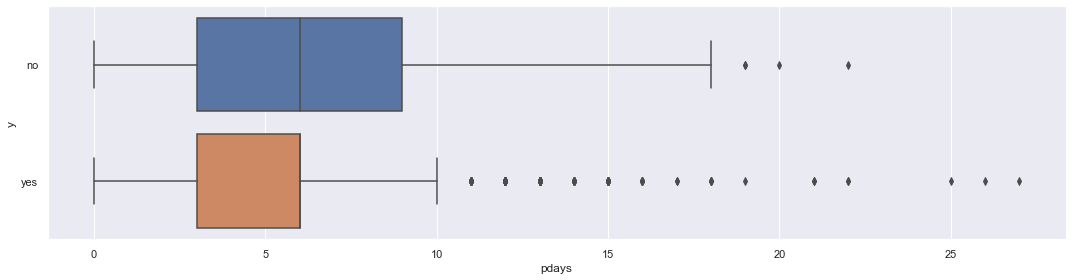

In [6]:
f = plt.figure(figsize=(15, 4))
sns.boxplot(x=df['pdays'], y=df['y'])
f.tight_layout()
plt.show()

The positive outcomes have a shorter **pdays** value.  So, let's keep the feature, but convert it to a categorical column and drop the numeric column. 

In [7]:
pdays_columns = ['no_contact', 'contact_0_5', 'contact_5_10', 'contact_10_15', 'contact_20']

df[pdays_columns[0]] = 0
df[pdays_columns[0]][df.pdays.isnull()] = 1

df[pdays_columns[1]] = 0
df[pdays_columns[1]][df.pdays <= 5] = 1

df[pdays_columns[2]] = 0
df[pdays_columns[2]][(df.pdays > 5) & (df.pdays <= 10)] = 1

df[pdays_columns[3]] = 0
df[pdays_columns[3]][(df.pdays > 15) & (df.pdays <= 20)] = 1

df[pdays_columns[4]] = 0
df[pdays_columns[4]][df.pdays > 20] = 1
                                     
df.drop('pdays', axis=1, inplace=True);
numeric_columns.remove('pdays')
categorical_columns = categorical_columns + pdays_columns

### Now let's look at the value counts for the categorical columns (sans dummies we just built). 

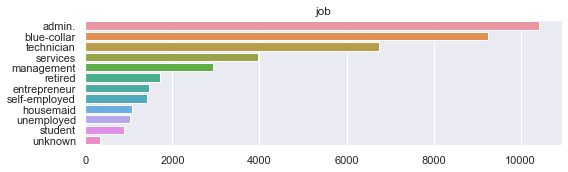

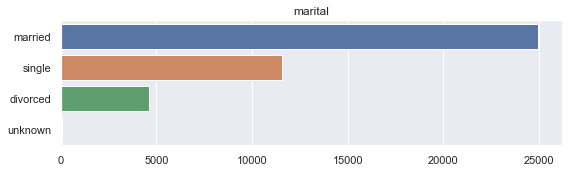

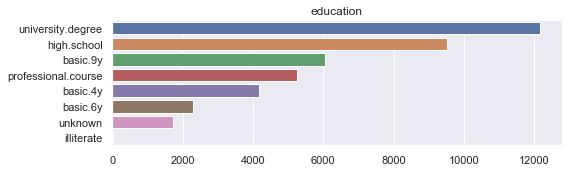

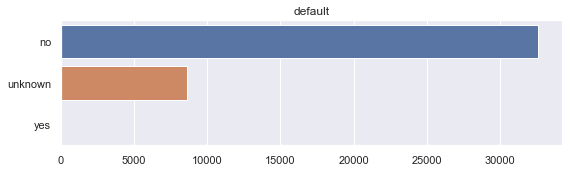

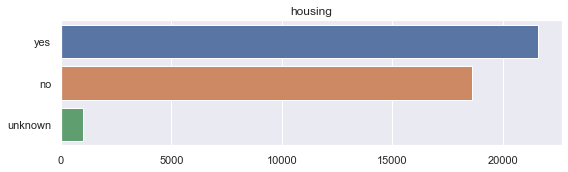

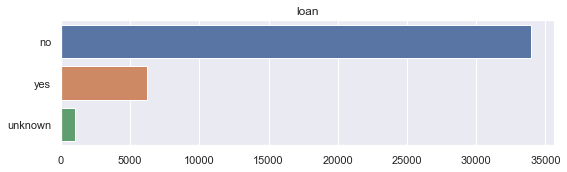

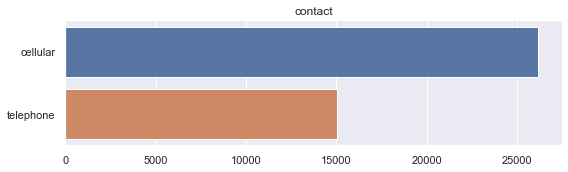

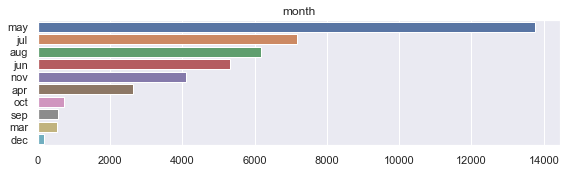

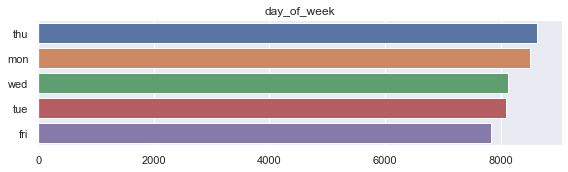

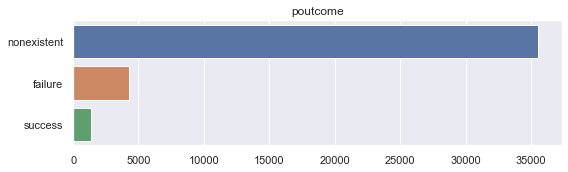

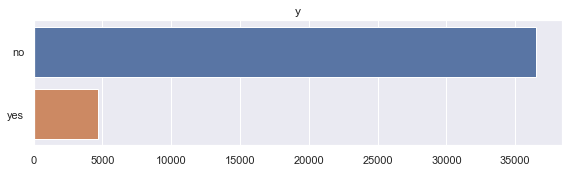

In [8]:
categorical_columns_sans_pdays = [c for c in categorical_columns if c not in pdays_columns]
for col in categorical_columns_sans_pdays:
    plt.figure(figsize=(8,2.5))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()   

### For numeric features, let's look at histograms. 

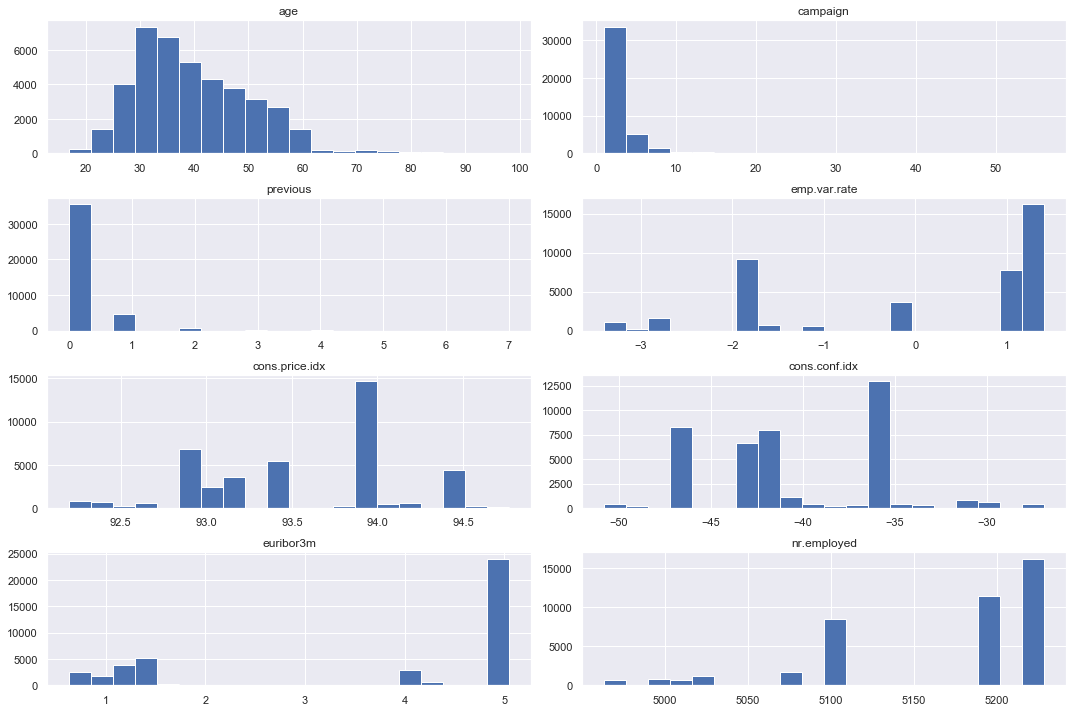

In [9]:
i = 0
j = 0
row_count = len(numeric_columns) // 2
f = plt.figure(figsize=(15, 10))
gs = f.add_gridspec(row_count, 2)

for col in numeric_columns:
    ax = f.add_subplot(gs[i, j])
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

# Logistic Regression 
Our goal is to use Random Forest, but it still makes sense to take a quick look at Logistic Regression.  This will give us a target goal for RF to exceed.

### Build dummies for Logistic Regression

In [10]:
df_dummies = pd.get_dummies(df)

### Scale all features

In [11]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

df_dummies = getScaledDataFrame(df_dummies)

## Clean and Scaled DataFrame

In [12]:
de = extended_describe(df_dummies)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,0.284248,0.128657,0.0,0.185185,0.259259,0.370370,1.0,78.0,0.0,False
campaign,41188.0,0.028502,0.050364,0.0,0.000000,0.018182,0.036364,1.0,42.0,0.0,False
previous,41188.0,0.024709,0.070700,0.0,0.000000,0.000000,0.000000,1.0,8.0,0.0,False
emp.var.rate,41188.0,0.725393,0.327283,0.0,0.333333,0.937500,1.000000,1.0,10.0,0.0,False
cons.price.idx,41188.0,0.535723,0.225581,0.0,0.340608,0.603274,0.698753,1.0,26.0,0.0,False
cons.conf.idx,41188.0,0.430854,0.193648,0.0,0.338912,0.376569,0.602510,1.0,26.0,0.0,False
euribor3m,41188.0,0.677237,0.393210,0.0,0.160961,0.957379,0.980957,1.0,316.0,0.0,False
nr.employed,41188.0,0.769134,0.273163,0.0,0.512287,0.859735,1.000000,1.0,11.0,0.0,False
no_contact,41188.0,0.963217,0.188230,0.0,1.000000,1.000000,1.000000,1.0,2.0,0.0,False


### Let's take a quick look at covariance between features

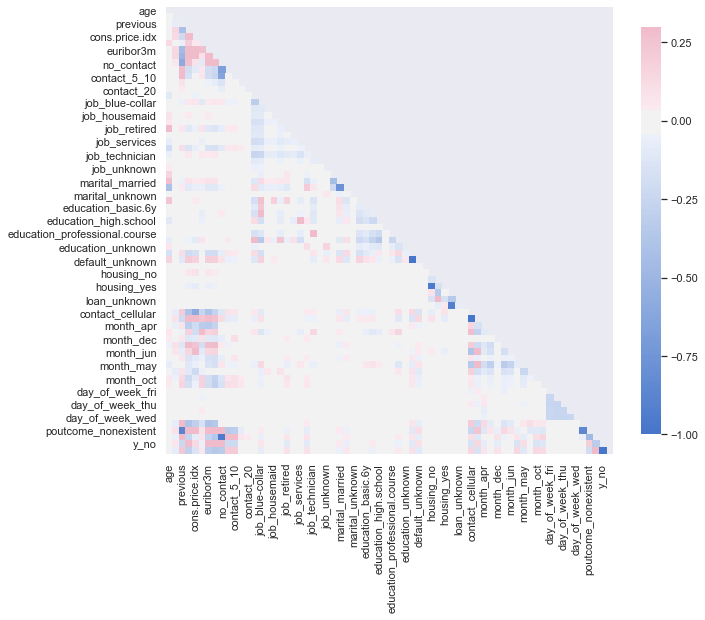

In [13]:
corr = df_dummies.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(255, 0, as_cmap=True)

f = plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, cbar_kws={"shrink": .75})

## Split into Train and Test

In [14]:
def dummies_train_test(train_size):
    train, test = train_test_split(df_dummies, train_size=train_size, random_state=42)

    print('Means of Positive Output Variable\nOriginal: {:.6f}\nTrain: {:.6f}\nTest: {:.6f}'.format(
                                                                                    (df_dummies.y_yes).mean(), 
                                                                                    (train.y_yes).mean(),
                                                                                    (test.y_yes).mean()))
    print('\nRowCounts\nTrain: {:,}\nTest: {:,}'.format(len(train), len(test)))

    feature_columns = df_dummies.columns[0:len(df_dummies.columns) - 2] #Remove both y_yes and y_no
    x_train = train[feature_columns].copy()
    y_train = train['y_yes'].copy()
    x_test = test[feature_columns].copy()
    y_test = test['y_yes'].copy()
    return feature_columns, x_train, y_train, x_test , y_test 

In [15]:
dummies_feature_columns, x_train, y_train, x_test , y_test = dummies_train_test(0.80)

Means of Positive Output Variable
Original: 0.112654
Train: 0.112443
Test: 0.113498

RowCounts
Train: 32,950
Test: 8,238


In [16]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 42, solver='saga')
logit.fit(x_train, y_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### Let's look at the top features that influenced our mode

In [17]:
print('Intercept: ', logit.intercept_)
de = pd.DataFrame({'column':dummies_feature_columns, 'model_slope':logit.coef_[0].transpose()})
de.reindex(de.model_slope.abs().sort_values().index)
de.loc[(de.model_slope.abs()).sort_values(ascending=False).index][['column', 'model_slope']].head(10)

Intercept:  [0.26259623]


,column,model_slope
3,emp.var.rate,-5.233591
4,cons.price.idx,3.620031
1,campaign,-2.338580
53,month_mar,1.256527
8,no_contact,-1.206980
6,euribor3m,1.077335
11,contact_10_15,-1.033988
54,month_may,-0.597961
55,month_nov,-0.562541
33,education_illiterate,0.542316


### Use our Logistic Regression model to predict on our test data. 

In [18]:
y_pred = logit.predict(x_test)

Let's display the Confusion Matrics in a way that show the meaning of the 4 values. 

In [19]:
def display_confusion_matrix(y_test, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    global TN
    global FP
    global FN
    global TP
    TN = int(confusion_matrix[0,0])
    FP = int(confusion_matrix[0,1])
    FN = int(confusion_matrix[1,0])
    TP = int(confusion_matrix[1,1])
    str_cm = [
                ['TN: {:,}'.format(TN), 'FP: {:,}'.format(FP)],
                ['FN: {:,}'.format(FN), 'TP: {:,}'.format(TP)]
             ] 
    dcm = pd.DataFrame(str_cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    return confusion_matrix, dcm

#### We could use SKLearn to do this, but let's get the TPR and FPA manfully as an exercise. 

In [20]:
def print_confusion_matrix(confusion_matrix):
    test_count = confusion_matrix.sum()
    success_count = int(confusion_matrix[0,0]) + int(confusion_matrix[1,1])
    accuracy = success_count / test_count
    TPR = TP / (TP + FN)
    FPR = FN / (FN + TP)
    # print('Accuracy: {:%}'.format(metrics.accuracy_score(y_test, y_pred)))
    # print('Sensitivity (TPR): {:%}'.format(metrics.recall_score(y_test, y_pred)))
    print('Accuracy: {:%}'.format(accuracy))
    print('Sensitivity (TPR): {:%}'.format(TPR))
    print('FPR: {:%}'.format(FPR))

In [21]:
confusion_matrix, dcm = display_confusion_matrix(y_test, y_pred)
display(dcm)
print_confusion_matrix(confusion_matrix)

,Predicted Negative,Predicted Positive
Actual Negative,"TN: 6,940",FP: 363
Actual Positive,FN: 586,TP: 349


Accuracy: 88.480214%
Sensitivity (TPR): 37.326203%
FPR: 62.673797%


### ROC Curve for out Logistic Regession

In [22]:
def plot_ROC(y_pred_proba, y_test, show_ideal=False):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = metrics.auc(fpr, tpr)

    f = plt.figure(figsize=(12, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    if show_ideal:
        ideal_x = list(range(len(fpr)))
        ideal_y = [1] * len(tpr)
        plt.plot(ideal_x, ideal_y, 'b', label = 'Ideal AUC=1', color='g', linewidth=10)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

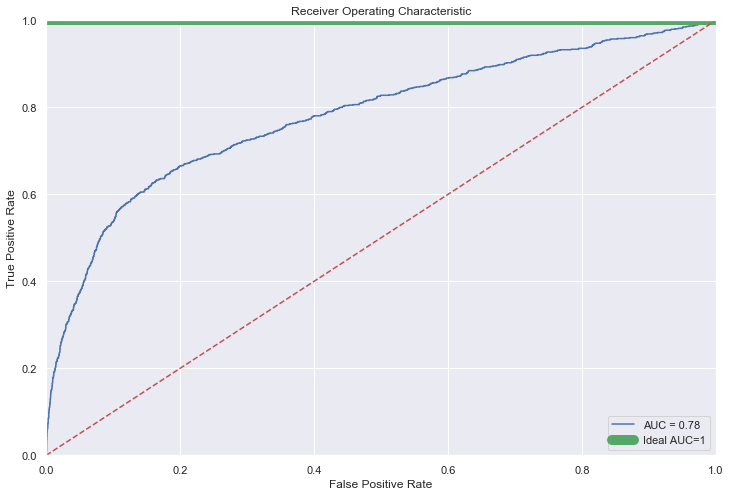

In [23]:
y_pred_proba = logit.predict_proba(x_test)
plot_ROC(y_pred_proba, y_test, True)

The ideal predictive model would have reached 100% sensitivity with 0% False Positives.  So the ideal curve would stay at 1 and the area under the curve $ \int_{0}^{1} y(x) dx = 1 $ 
  
The Logistic Regression curve obtains **80%** of the ideal area.  Looking at the curve, you can see that TPR raises fairly fast, but around TPR = 60%, gains in TRP come at the expense of False Positives. 
  
Let's see if Random Forest can do better. 

## Logistic Regression Cross Validation

In [24]:
scores = cross_val_score(logit, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.01)


In [25]:
def plot_ROC_cross_validation(clf, x, y, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (train, test) in enumerate(cv.split(x, y)):
        clf.fit(x.iloc[train], y.iloc[train])
        viz = metrics.plot_roc_curve(clf, x.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()

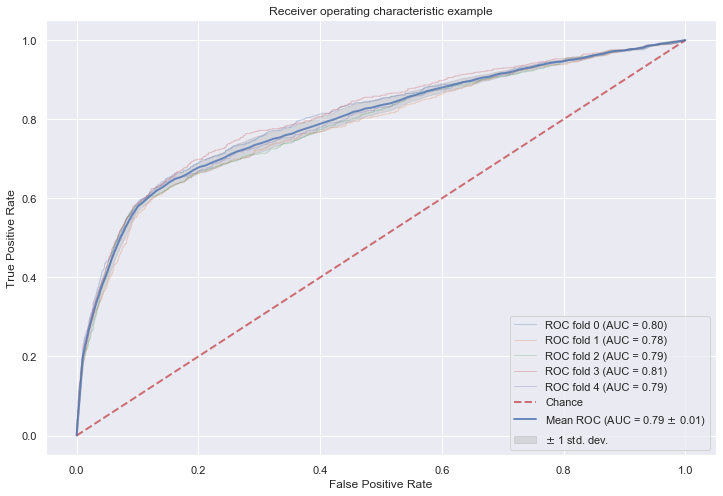

In [26]:
dummies_cv = StratifiedKFold(n_splits=5)
plot_ROC_cross_validation(logit, x_train, y_train, dummies_cv)

# Random Forest

## No Dummies or Scaling for RF, but we need to LabelEncode

In [27]:
encoder = LabelEncoder()
df_rf = df.copy()
for c in categorical_columns_sans_pdays:
    encoder.fit(df_rf[c])
    df_rf[c] = encoder.transform(df_rf[c])
# display(df_rf)
de = extended_describe(df_rf)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,78.0,0.0,False
job,41188.0,3.724580,3.594560,0.000,0.000,2.000,7.000,11.000,12.0,0.0,False
marital,41188.0,1.172769,0.608902,0.000,1.000,1.000,2.000,3.000,4.0,0.0,False
education,41188.0,3.747184,2.136482,0.000,2.000,3.000,6.000,7.000,8.0,0.0,False
default,41188.0,0.208872,0.406686,0.000,0.000,0.000,0.000,2.000,3.0,0.0,False
housing,41188.0,1.071720,0.985314,0.000,0.000,2.000,2.000,2.000,3.0,0.0,False
loan,41188.0,0.327425,0.723616,0.000,0.000,0.000,0.000,2.000,3.0,0.0,False
contact,41188.0,0.365252,0.481507,0.000,0.000,0.000,1.000,1.000,2.0,0.0,False
month,41188.0,4.230868,2.320025,0.000,3.000,4.000,6.000,9.000,10.0,0.0,False


### Split Train and Test 
Very similar approach to Logistic Regression. Train is 80%, but we have to do a couple of changes since the two DataFrames have been prepared differently. 

Let's make it a function since we might want to reuse this more than one time.

In [28]:
def train_test_split_RF(test_percent):
    df_split = df_rf.copy()
    train, test = train_test_split(df_split, train_size=test_percent, random_state=42)

    print('Means of Positive Output Variable\nOriginal: {:.6f}\nTrain: {:.6f}\nTest: {:.6f}'.format(
                                                                                    (df_split.y).mean(), 
                                                                                    (train.y).mean(),
                                                                                    (test.y).mean()))
    print('\nRowCounts\nTrain: {:,}\nTest: {:,}'.format(len(train), len(test)))
    
    
    x_train = train.drop(['y'], axis=1).copy()
    y_train = train['y'].copy()
    x_test = test.drop(['y'], axis=1).copy()
    y_test = test['y'].copy()
    return x_train, y_train, x_test , y_test

In [29]:
x_train, y_train, x_test , y_test = train_test_split_RF(0.80)

Means of Positive Output Variable
Original: 0.112654
Train: 0.112443
Test: 0.113498

RowCounts
Train: 32,950
Test: 8,238


### Random Forest Train and Predict
We can loop to get a good starting point for number of trees, but we will try 100 to see if this will be a good start.

In [30]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
%time
rf_clf.fit(x_train, y_train)
%time
y_pred = rf_clf.predict(x_test)

Wall time: 0 ns
Wall time: 0 ns


Return is instantons, so no need to backoff on **n_estimators**. 

In [31]:
confusion_matrix, dcm = display_confusion_matrix(y_test, y_pred)
display(dcm)
print_confusion_matrix(confusion_matrix)

,Predicted Negative,Predicted Positive
Actual Negative,"TN: 7,068",FP: 235
Actual Positive,FN: 666,TP: 269


Accuracy: 89.062879%
Sensitivity (TPR): 28.770053%
FPR: 71.229947%


### RF ROC

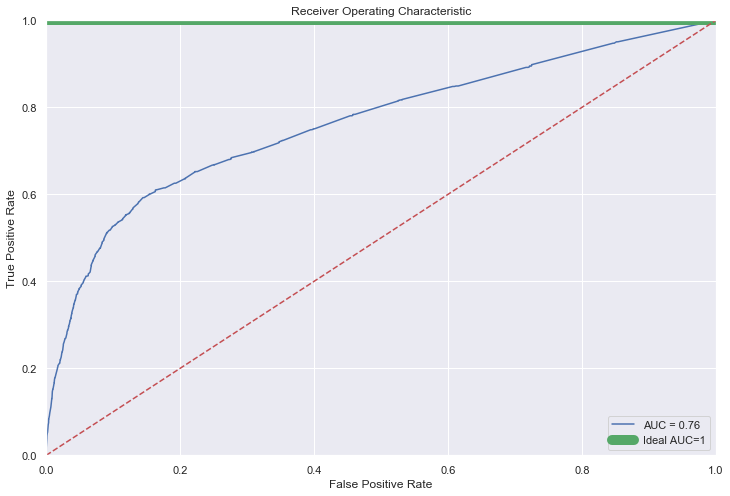

In [32]:
y_pred_proba = rf_clf.predict_proba(x_test)
plot_ROC(y_pred_proba, y_test, True)

### Feature Importance

In [33]:
feature_columns = x_train.columns
rf_feature_importance = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rf_clf.feature_importances_), feature_columns),reverse=True))
rf_feature_importance.head(10)

,0,1
0,0.1846,age
1,0.1392,euribor3m
2,0.0858,campaign
3,0.0849,job
4,0.0746,education
5,0.0608,day_of_week
6,0.0517,nr.employed
7,0.0407,marital
8,0.0365,housing
9,0.0305,poutcome


## Poor Results, so let's try to find better hyperparameters

In [34]:
def plot_RF_hyperparameter(train_scores, test_scores, param_range, param_name):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="black")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    # Create plot
    plt.title("Validation Curve With Random Forest")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

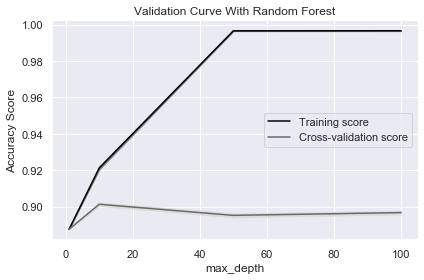

In [35]:
param_range = [1, 10, 50, 100]
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = param_range, cv = 3)
plot_RF_hyperparameter(train_scores, test_scores, param_range, 'max_depth')

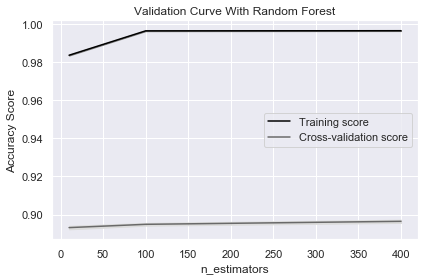

In [36]:
param_range = [10, 100, 400]
train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = x_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = param_range, cv = 3)
plot_RF_hyperparameter(train_scores, test_scores, param_range, 'n_estimators')

In [37]:
x_train, y_train, x_test , y_test = train_test_split_RF(0.80) #just be safe and rebuild train/test
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

In [38]:
confusion_matrix, dcm = display_confusion_matrix(y_test, y_pred)
display(dcm)
print_confusion_matrix(confusion_matrix)

,Predicted Negative,Predicted Positive
Actual Negative,"TN: 7,169",FP: 134
Actual Positive,FN: 716,TP: 219


Accuracy: 89.681962%
Sensitivity (TPR): 23.422460%
FPR: 76.577540%


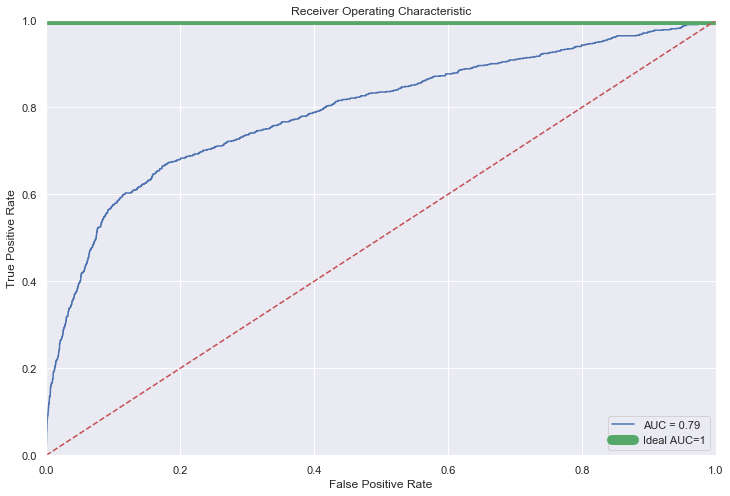

In [39]:
y_pred_proba = rf_clf.predict_proba(x_test)
plot_ROC(y_pred_proba, y_test, True)

## Feature Importance

In [48]:
feature_columns = x_train.columns
rf_feature_importance = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rf_clf.feature_importances_), feature_columns),reverse=True))
rf_feature_importance.head(10)

,0,1
0,0.1785,job_housemaid
1,0.1515,job_management
2,0.0741,job_retired
3,0.0705,contact_20
4,0.0684,job_admin.
5,0.0585,age
6,0.0583,job_entrepreneur
7,0.0532,job_blue-collar
8,0.0439,no_contact
9,0.0298,contact_0_5


## Random Forest - Cross Validation

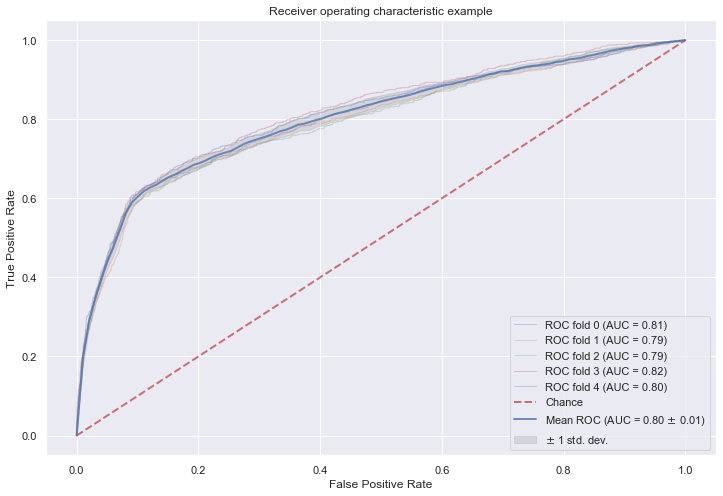

In [41]:
dummies_rf = StratifiedKFold(n_splits=5)
plot_ROC_cross_validation(rf_clf, x_train, y_train, dummies_rf)

## Random Forest has better accuracy, but much lower sensitivity.   
So, let's try another classifier. 

## Support Vector Machine

#### We will use the dummies version of the DataFrame

In [42]:
# Reset train and test to dummies
dummies_feature_columns, x_train, y_train, x_test , y_test = dummies_train_test(0.80)

Means of Positive Output Variable
Original: 0.112654
Train: 0.112443
Test: 0.113498

RowCounts
Train: 32,950
Test: 8,238


In [43]:
svm_clf = svm.SVC(C=1, class_weight={1:2}, random_state = 42, decision_function_shape='ovo')
svm_clf.fit(x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight={1: 2}, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [44]:
y_pred = svm_clf.predict(x_test)

In [45]:
confusion_matrix, dcm = display_confusion_matrix(y_test, y_pred)
display(dcm)
print_confusion_matrix(confusion_matrix)

,Predicted Negative,Predicted Positive
Actual Negative,"TN: 6,899",FP: 404
Actual Positive,FN: 556,TP: 379


Accuracy: 88.346686%
Sensitivity (TPR): 40.534759%
FPR: 59.465241%


In [46]:
scores = cross_val_score(svm_clf, x_train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.01)


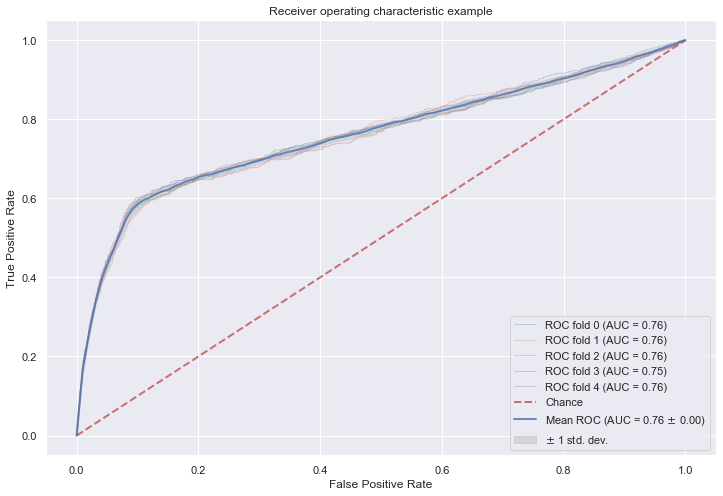

In [47]:
dummies_cv = StratifiedKFold(n_splits=5)
plot_ROC_cross_validation(svm_clf, x_train, y_train, dummies_cv)

# Conclusion  
Hard to determine which classifier was better without a target accuracy.  SVM looks like it has more accuracy and sensitive, but extensive tuning effort with all 3 models might yield different results. 